### 整合性

$a_{jk}^\text{L} w_k^\text{U} = w_j^\text{L}, ~ a_{jk}^\text{U} w_k^\text{L} = w_j^\text{U}, w_j^\text{L} \leq w_j^\text{U}, ~ j, k \in N, ~ j \neq k$ を満たす解が唯一存在することの必要十分条件は次の通り．

任意の $i \in N$ について次の式すべてが成り立つ．
$$
a_{ij}^\text{L} a_{jk}^\text{U} a_{ki}^\text{L} = a_{is}^\text{L} a_{sr}^\text{U} a_{ri}^\text{L}, ~~
j \neq k, ~~ s \neq r, ~~ j, k, s, r \in N \backslash \{ i \}
$$

$$
a_{ij}^\text{L} a_{jk}^\text{U} a_{ki}^\text{L} \leq 1, ~~
a_{si}^\text{K} \leq a_{sr}^\text{U} a_{ri}^\text{L}, ~~
j \neq k, ~~ s \neq r, ~~ j, k, s, r \in N \backslash \{ i \}
$$

$$
\begin{aligned}
& \min \left(
    a_{ij}^\text{L} a_{jk}^\text{U} a_{ki}^\text{L} +
    a_{jk}^\text{U} a_{ki}^\text{L} +
    \sum_{r \in N \backslash \{ i, j \}} a_{rj}^\text{U} a_{ji}^\text{L}, ~
    \min_{r \in N \backslash N \{ i \}} \left(
        a_{ri}^\text{L} + 1 + \sum_{s \in N \backslash \{ i, r \}} a_{sr}^\text{U} a_{ri}^\text{L}
    \right)
\right) \\ & ~~~~
\geq \max\left(
    1 + \sum_{r \in N \backslash \{ i \}} a_{ri}^\text{L}, ~~
    a_{jk}^\text{U} a_{ki}^\text{L} +
    a_{ij}^\text{L} a_{jk}^\text{U} a_{ki}^\text{L} +
    \sum_{r \in N \backslash \{ i, j \}} a_{ri}^\text{L},
    \right. \\ & \hspace{50pt} \left.
    \max_{r \in N \backslash \{ i, j \}} \left(
        a_{rj}^\text{U} a_{ji}^\text{L} +
        a_{ij}^\text{L} a_{jk}^\text{U} a_{ki}^\text{L} +
        \sum_{s \in N \backslash \{ i, r \}} a_{ri}^\text{L}
    \right)
\right).
\end{aligned}
$$

上 ２ つで解の存在性を担保できる． 3 つ目は解の唯一性に関連する．

In [1]:
using IntervalArithmetic
using LaTeXStrings
using Plots

In [2]:
include("./heatmap/index.jl")
include("./method1/index.jl")
include("./method2/index.jl")
include("./method3/index.jl")
include("./method4/index.jl")
include("./intervalPCM/index.jl")
include("./twofoldInterval/index.jl")
include("./twofoldIntervalPCM/index.jl")

print()

In [3]:
function method1(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    A = intervalPCM2TwofoldIntervalPCM(A₁, A₂)
    result = solveLP_m1(A)
    Â = updatePCM_m1(A, result)
    return Â
end

method1 (generic function with 1 method)

In [4]:
function  method2(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    εᶿ = solveIndividualCancellingLP_m2([A₁, A₂])
    result = solveApproximationLP_m2([A₁, A₂], εᶿ)
    A = importance2TwofoldIntervalPCM_m2(result)
    return A
end

method2 (generic function with 1 method)

In [5]:
function method3(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    approximationResults = solveApproximationLP_m3.([A₁, A₂])
    tBoundaries = calculateTBoundaries_m3.(approximationResults)
    result = solveConcatLP_m3(approximationResults, tBoundaries)
    Â = generatePCM_m3(result)
    return Â
end

method3 (generic function with 1 method)

In [6]:
function method4(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    results = solveApproximationLP_m4.([A₁, A₂])
    A = generateTwofoldIntervalMatrix_m4(results)
    result = solveCancellingLP_m4(A)
    Â = updatePCM_m4(A, result)
    return Â
end

method4 (generic function with 1 method)

In [7]:
# 対角成分以外の算術平均
function mean(A::Matrix{T})::T where {T <: Real}
    m, n = size(A)

    if m != n return 0 end
    if n == 1 return 0 end

    a = 0
    for i = 1:m, j = 1:n
        if i == j continue end
        a += A[i,j]
    end

    return a / n / (n-1)
end

titles = [
    "行列を結合して二重区間PCMを作り，整合化",
    "整合化しながら結合した重要度を求めて二重区間PCMにする",
    "DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする",
    "DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"
]

function plotAll(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}, size::Tuple{Integer, Integer}=(1000, 250)) where {T <: Real}
    m = 2 # DM の数

    matrices = [A₁, A₂]
    resultMatrices = twofoldIntervalMatrix2intervalMatrices.(
        [method1(A₁, A₂), method2(A₁, A₂), method3(A₁, A₂), method4(A₁, A₂)])
    
    p = []; a = []; indmat = []
    for k = 1:length(resultMatrices)
        h = []; indrow = []
        Âₖ⁻, Âₖ⁺ = resultMatrices[k]
        for l = 1:m
            title⁻ = L"S( A_{%$(l)ij}, \hat{A}_{%$(k)ij}^- )"
            title⁺ = L"S( A_{%$(l)ij}, \hat{A}_{%$(k)ij}^+ )"

            heatmap⁻, indices⁻ = plotConincidenceIndices(matrices[l], Âₖ⁻, title⁻)
            heatmap⁺, indices⁺ = plotConincidenceIndices(matrices[l], Âₖ⁺, title⁺)

            push!(h, heatmap⁻); push!(h, heatmap⁺)
            push!(indrow, indices⁻); push!(indrow, indices⁺)
        end

        push!(p, h); push!(a, [Âₖ⁻, Âₖ⁺])
        push!(indmat, indrow)
    end

    for i = eachindex(p)
        display(titles[i])
        A = intervalPCM2TwofoldIntervalPCM(a[i][1], a[i][2])
        display(L"\hat{A}_{%$(i)} = %$(twofoldIntervalMatrixLaTeXString(A))")
        display(plot(p[i]..., layout=(1, 4), size=size, legend=false))
        display("非対角成分の算術平均: $(round(mean(indmat[i][1]), digits=3)), $(round(mean(indmat[i][2]), digits=3)), $(round(mean(indmat[i][3]), digits=3)), $(round(mean(indmat[i][4]), digits=3))")
    end
end

plotAll (generic function with 2 methods)

整合している同じ行列 2 つ

L"$A_1 = A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.0, 2.0 \right] & \left[ 0.667, 1.333 \right] & \left[ 1.0, 1.333 \right] \\ \left[ 0.5, 1.0 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.444, 1.0 \right] & \left[ 0.667, 1.0 \right] \\ \left[ 0.75, 1.5 \right] & \left[ 1.0, 2.25 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.0, 1.5 \right] \\ \left[ 0.75, 1.0 \right] & \left[ 1.0, 1.5 \right] & \left[ 0.667, 1.0 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

true

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   2.0 \\right],   2.0 \\right] & \\left[ 0.667, \\left[ 0.667, 1.333 \\right], 1.333 \\right] & \\left[   1.0, \\left[   1.0, 1.333 \\right], 1.333 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht],   1.5 \\right] \\\\ \\left[  0.75, \\left[  0.75,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   1.5 \\right],   1.5 \\right] & \\left[ 0.667, \\left[ 0.667,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

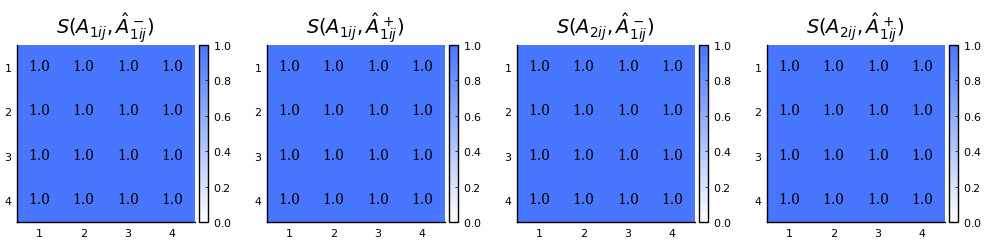

"非対角成分の算術平均: 1.0, 1.0, 1.0, 1.0"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   2.0 \\right],   2.0 \\right] & \\left[ 0.667, \\left[ 0.667, 1.333 \\right], 1.333 \\right] & \\left[   1.0, \\left[   1.0, 1.333 \\right], 1.333 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht],   1.5 \\right] \\\\ \\left[  0.75, \\left[  0.75,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   1.5 \\right],   1.5 \\right] & \\left[ 0.667, \\left[ 0.667,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

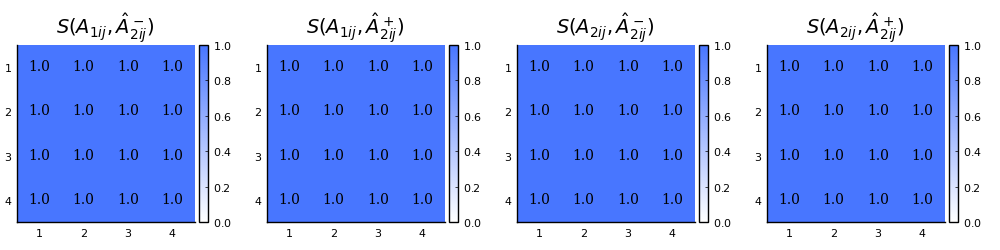

"非対角成分の算術平均: 1.0, 1.0, 1.0, 1.0"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   2.0 \\right],   2.0 \\right] & \\left[ 0.667, \\left[ 0.667, 1.333 \\right], 1.333 \\right] & \\left[   1.0, \\left[   1.0, 1.333 \\right], 1.333 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht],   1.5 \\right] \\\\ \\left[  0.75, \\left[  0.75,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   1.5 \\right],   1.5 \\right] & \\left[ 0.667, \\left[ 0.667,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

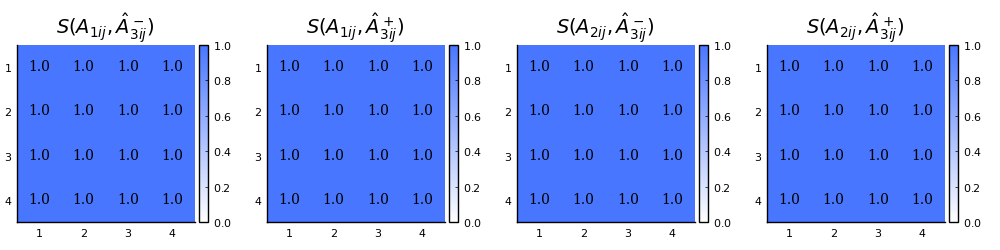

"非対角成分の算術平均: 1.0, 1.0, 1.0, 1.0"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   2.0 \\right],   2.0 \\right] & \\left[ 0.667, \\left[ 0.667, 1.333 \\right], 1.333 \\right] & \\left[   1.0, \\left[   1.0, 1.333 \\right], 1.333 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht],   1.5 \\right] \\\\ \\left[  0.75, \\left[  0.75,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   1.5 \\right],   1.5 \\right] & \\left[ 0.667, \\left[ 0.667,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

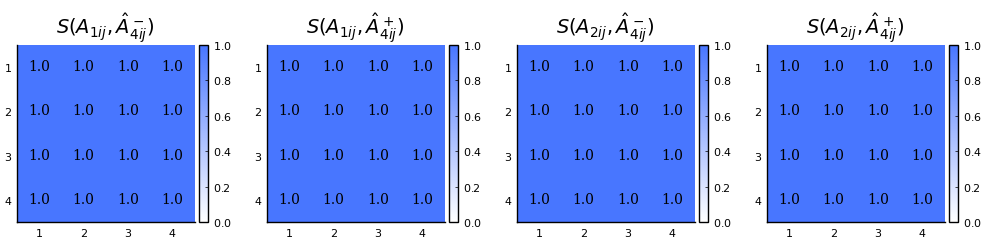

"非対角成分の算術平均: 1.0, 1.0, 1.0, 1.0"

In [14]:
A₁ = [
    1..1 1..2 (2/3)..(4/3) 1..(4/3)
    (1/2)..1 1..1 (4/9)..1 (2/3)..1
    (3/4)..(3/2) 1..(9/4) 1..1 1..(3/2)
    (3/4)..1 1..(3/2) (2/3)..1 1..1
]
A₂ = A₁

display(L"A_1 = A_2 = %$(intervalMatrixLaTeXString(A₁))")

display(isConsistentIntervalPCM(A₁))

plotAll(A₁, A₂)

ともに整合していて， $A_{1ij} \subseteq A_{2ij}$

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.0, 2.0 \right] & \left[ 0.667, 1.333 \right] & \left[ 1.0, 1.333 \right] \\ \left[ 0.5, 1.0 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.444, 1.0 \right] & \left[ 0.667, 1.0 \right] \\ \left[ 0.75, 1.5 \right] & \left[ 1.0, 2.25 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.0, 1.5 \right] \\ \left[ 0.75, 1.0 \right] & \left[ 1.0, 1.5 \right] & \left[ 0.667, 1.0 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 0.96, 2.083 \right] & \left[ 0.64, 1.389 \right] & \left[ 0.96, 1.389 \right] \\ \left[ 0.48, 1.042 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.427, 1.042 \right] & \left[ 0.64, 1.042 \right] \\ \left[ 0.72, 1.562 \right] & \left[ 0.96, 2.344 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.96, 1.562 \right] \\ \left[ 0.72, 1.042 \right] & \left[ 0.96, 1.562 \right] & \left[ 0.64, 1.042 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

true

true

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[  0.96, \\left[   1.0,   2.0 \\right], 2.083 \\right] & \\left[  0.64, \\left[ 0.667, 1.333 \\right], 1.389 \\right] & \\left[  0.96, \\left[   1.0, 1.333 \\right], 1.389 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.562 \\right] \\\\ \\left[  0.72, \\left[  0.75,   1.0 \\right], 1.042 \\right] & \\left[  0.96, \\left[   1.0,   1.5 \\right], 1.562 \\right] & \\left[  0.64, \\left[ 0.667,   1.0 \\right], 1.042 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

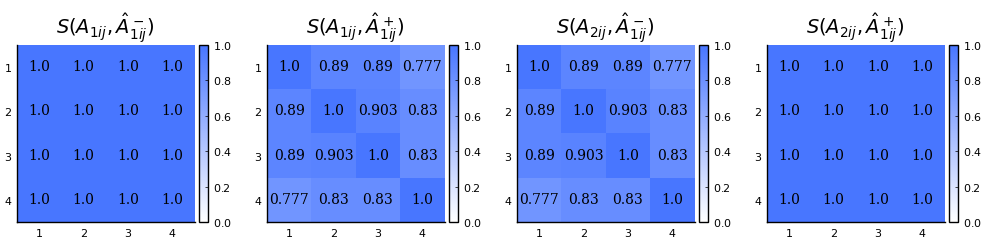

"非対角成分の算術平均: 1.0, 0.853, 0.853, 1.0"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[  0.96, \\left[   1.0,   2.0 \\right], 2.083 \\right] & \\left[  0.64, \\left[ 0.667, 1.333 \\right], 1.389 \\right] & \\left[  0.96, \\left[   1.0, 1.333 \\right], 1.389 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.563 \\right] \\\\ \\left[  0.72, \\left[  0.75,   1.0 \\right], 1.042 \\right] & \\left[  0.96, \\left[   1.0,   1.5 \\right], 1.562 \\right] & \\left[  0.64, \\left[ 0.667,   1.0 \\right], 1.042 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

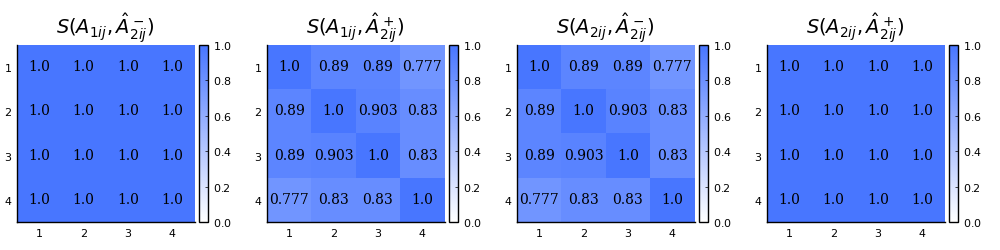

"非対角成分の算術平均: 1.0, 0.853, 0.853, 1.0"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[  0.96, \\left[   1.0,   2.0 \\right], 2.083 \\right] & \\left[  0.64, \\left[ 0.667, 1.333 \\right], 1.389 \\right] & \\left[  0.96, \\left[   1.0, 1.333 \\right], 1.389 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.562 \\right] \\\\ \\left[  0.72, \\left[  0.75,   1.0 \\right], 1.042 \\right] & \\left[  0.96, \\left[   1.0,   1.5 \\right], 1.563 \\right] & \\left[  0.64, \\left[ 0.667,   1.0 \\right], 1.042 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

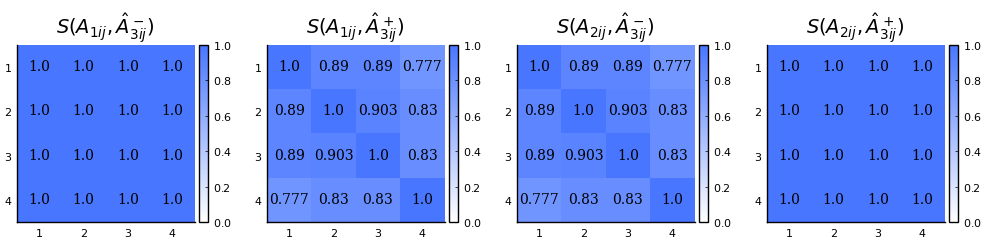

"非対角成分の算術平均: 1.0, 0.853, 0.853, 1.0"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[  0.96, \\left[   1.0,   2.0 \\right], 2.083 \\right] & \\left[  0.64, \\left[ 0.667, 1.333 \\right], 1.389 \\right] & \\left[  0.96, \\left[   1.0, 1.333 \\right], 1.389 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.562 \\right] \\\\ \\left[  0.72, \\left[  0.75,   1.0 \\right], 1.042 \\right] & \\left[  0.96, \\left[   1.0,   1.5 \\right], 1.562 \\right] & \\left[  0.64, \\left[ 0.667,   1.0 \\right], 1.042 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

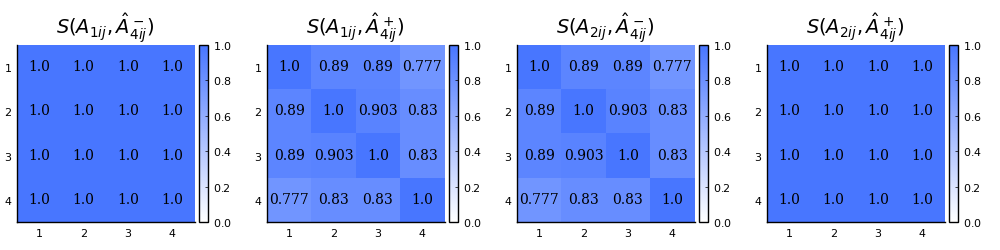

"非対角成分の算術平均: 1.0, 0.853, 0.853, 1.0"

In [9]:
A₁ = [
    1..1 1..2 (2/3)..(4/3) 1..(4/3)
    (1/2)..1 1..1 (4/9)..1 (2/3)..1
    (3/4)..(3/2) 1..(9/4) 1..1 1..(3/2)
    (3/4)..1 1..(3/2) (2/3)..1 1..1
]
_, n = size(A₁)
A₂ = fill(1..1, (n, n))
for i = 1:n, j = 1:n
    if i == j continue end
    A₂[i,j] = (A₁[i,j].lo * 4 / 5)..(A₁[i,j].hi * 5 / 4)
end

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isConsistentIntervalPCM(A₁))
display(isConsistentIntervalPCM(A₂))

plotAll(A₁, A₂)

<!-- ともに弱い整合性を持ち， $A_{1ij} \subseteq A_{2ij}$

```
A₁ = [
    1..1 2..5 2..4 2..3
    (1/5)..(1/2) 1..1 (1/5)..4 (1/5)..3
    (1/4)..(1/2) (1/4)..5 1..1 (1/4)..3
    (1/3)..(1/2) (1/3)..5 (1/3)..4 1..1
]
A₂ = fill(1..1, size(A₁))
_, n = size(A₁)
for i = 1:n, j = 1:n
    if i == j continue end
    A₂[i,j] = (A₁[i,j].lo * 1/1.1)..(A₁[i,j].hi * 1.1)
end

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isConsistentIntervalPCM(A₁))
display(isWeaklyConsistentIntervalPCM(A₁))
display(isConsistentIntervalPCM(A₂))
display(isWeaklyConsistentIntervalPCM(A₂))

plotAll(A₁, A₂)
``` -->

推移率が成り立つ通常の $4 \times 4$ PCM に幅を与えて整合していない行列　2 つを作る

$\begin{bmatrix} 1/2 & 2 & 4 & 4 \\ 1/2 & 1 & 2 & 2 \\ 1/4 & 1/2 & 1 & 1 \\ 1/4 & 1/2 & 1 & 1 \end{bmatrix}$ に自然対数スケールで $[0, 0.03]$ の一様分布に従う乱数の分だけ上下に幅をもたせている

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.981, 2.033 \right] & \left[ 3.974, 4.109 \right] & \left[ 3.958, 4.048 \right] \\ \left[ 0.492, 0.505 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.944, 2.048 \right] & \left[ 1.971, 2.045 \right] \\ \left[ 0.243, 0.252 \right] & \left[ 0.488, 0.515 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.983, 1.022 \right] \\ \left[ 0.247, 0.253 \right] & \left[ 0.489, 0.507 \right] & \left[ 0.978, 1.017 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.998, 2.01 \right] & \left[ 3.974, 4.05 \right] & \left[ 3.962, 4.041 \right] \\ \left[ 0.497, 0.5 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.945, 2.015 \right] & \left[ 1.942, 2.033 \right] \\ \left[ 0.247, 0.252 \right] & \left[ 0.496, 0.514 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.972, 1.021 \right] \\ \left[ 0.247, 0.252 \right] & \left[ 0.492, 0.515 \right] & \left[ 0.979, 1.029 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

false

false

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.981, \\left[ 1.998,  2.01 \\right], 2.043 \\right] & \\left[ 3.955, \\left[ 3.974,  4.05 \\right], 4.109 \\right] & \\left[ 3.958, \\left[ 3.962, 4.041 \\right], 4.058 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.023 \\right] \\\\ \\left[ 0.246, \\left[ 0.247, 0.252 \\right], 0.253 \\right] & \\left[ 0.489, \\left[ 0.492, 0.507 \\right], 0.516 \\right] & \\left[ 0.977, \\left[ 0.982, 1.017 \\right], 1.029 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

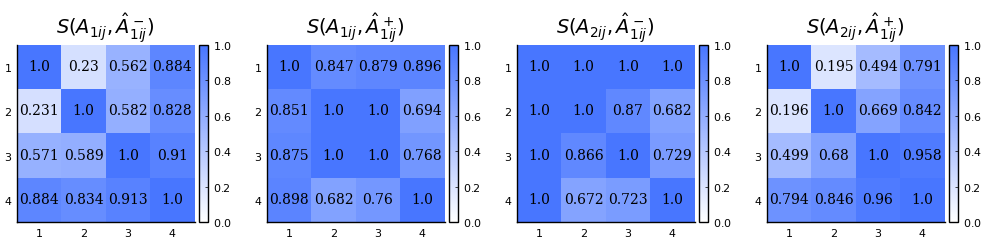

"非対角成分の算術平均: 0.668, 0.846, 0.879, 0.66"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.977, \\left[   2.0,  2.01 \\right], 2.033 \\right] & \\left[ 3.948, \\left[ 3.974, 4.031 \\right], 4.109 \\right] & \\left[ 3.944, \\left[ 3.962, 4.041 \\right], 4.048 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.024 \\right] \\\\ \\left[ 0.247, \\left[ 0.247, 0.252 \\right], 0.254 \\right] & \\left[ 0.489, \\left[ 0.495, 0.507 \\right], 0.515 \\right] & \\left[ 0.976, \\left[ 0.983, 1.017 \\right], 1.041 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

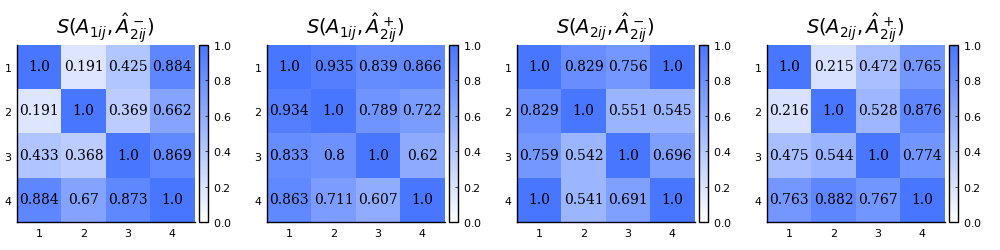

"非対角成分の算術平均: 0.568, 0.793, 0.728, 0.606"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.981, \\left[ 1.998, 2.021 \\right], 2.033 \\right] & \\left[ 3.948, \\left[ 3.974, 4.057 \\right], 4.071 \\right] & \\left[ 3.962, \\left[ 3.962, 4.055 \\right],  4.07 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.027 \\right] \\\\ \\left[ 0.246, \\left[ 0.247, 0.252 \\right], 0.252 \\right] & \\left[ 0.488, \\left[ 0.493,  0.51 \\right], 0.511 \\right] & \\left[ 0.973, \\left[  0.98, 1.022 \\right], 1.024 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

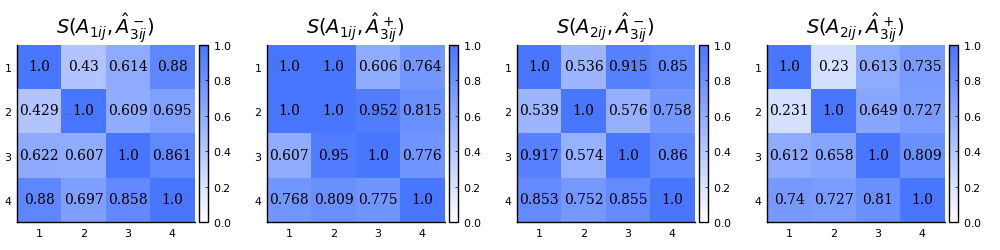

"非対角成分の算術平均: 0.682, 0.819, 0.749, 0.628"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.981, \\left[ 1.998,  2.01 \\right], 2.036 \\right] & \\left[ 3.931, \\left[ 3.974, 4.027 \\right], 4.109 \\right] & \\left[ 3.924, \\left[ 3.992, 4.041 \\right], 4.066 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.033 \\right] \\\\ \\left[ 0.246, \\left[ 0.247,  0.25 \\right], 0.255 \\right] & \\left[ 0.489, \\left[ 0.494, 0.507 \\right], 0.515 \\right] & \\left[ 0.968, \\left[ 0.985, 1.016 \\right], 1.034 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

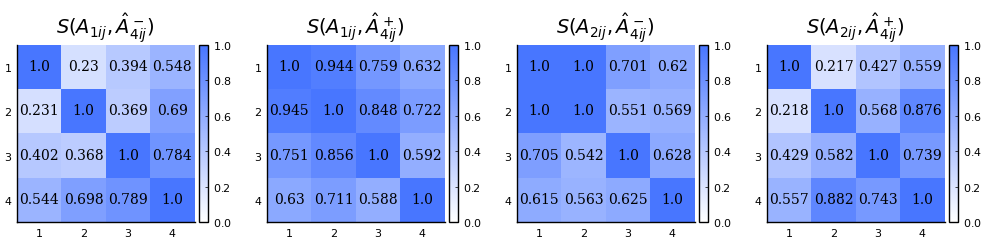

"非対角成分の算術平均: 0.504, 0.748, 0.676, 0.566"

In [10]:
A = [
    1 2 4 4
    1/2 1 2 2
    1/4 1/2 1 1
    1/4 1/2 1 1
]

A₁ = randamizedIntervalPCM(A, 1234, 3e-2)
A₂ = randamizedIntervalPCM(A, 134, 3e-2)

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isConsistentIntervalPCM(A₁))
display(isConsistentIntervalPCM(A₂))

plotAll(A₁, A₂)

<!-- 推移率が成り立つ通常の $4 \times 4$ PCM に幅を与えて整合していない行列 2 つを作る

$\begin{bmatrix} 1/2 & 2 & 4 & 4 \\ 1/2 & 1 & 2 & 2 \\ 1/4 & 1/2 & 1 & 1 \\ 1/4 & 1/2 & 1 & 1 \end{bmatrix}$ に自然対数スケールで $[0, 0.3]$ の一様分布に従う乱数の分だけ上下に幅をもたせている -->

<!-- 完全整合はしていない PCM にランダムに幅をもたせる

```
A = [
    1 2 4 4
    1/2 1 2 2
    1/4 1/2 1 1
    1/4 1/2 1 1
]

A₁ = randamizedIntervalPCM(A, 14, 3e-1)
A₂ = randamizedIntervalPCM(A, 1234, 3e-1)

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isConsistentIntervalPCM(A₁))
display(isConsistentIntervalPCM(A₂))

plotAll(A₁, A₂)
``` -->

In [11]:
using LinearAlgebra

A = [
    1 2 3 10
    1/2 1 3 8
    1/3 1/3 1 3
    1/10 1/8 1/3 1
]

_, n = size(A)

λ = maximum(real.(filter(e -> imag(e) == 0,eigvals(A))))
(λ - n) / (n - 1)

0.015252586019425252

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.477, 2.432 \right] & \left[ 2.334, 3.893 \right] & \left[ 8.353, 12.974 \right] \\ \left[ 0.411, 0.677 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.216, 3.049 \right] & \left[ 6.654, 8.351 \right] \\ \left[ 0.257, 0.428 \right] & \left[ 0.328, 0.451 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.263, 3.309 \right] \\ \left[ 0.077, 0.12 \right] & \left[ 0.12, 0.15 \right] & \left[ 0.302, 0.442 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.483, 2.772 \right] & \left[ 2.367, 3.578 \right] & \left[ 8.663, 11.158 \right] \\ \left[ 0.361, 0.674 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.786, 3.835 \right] & \left[ 6.615, 10.334 \right] \\ \left[ 0.279, 0.422 \right] & \left[ 0.261, 0.359 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.648, 4.048 \right] \\ \left[ 0.09, 0.115 \right] & \left[ 0.097, 0.151 \right] & \left[ 0.247, 0.378 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

false

false

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.073, \\emptyset, 2.772 \\right] & \\left[ 2.334, \\emptyset, 5.358 \\right] & \\left[ 8.353, \\emptyset, 14.677 \\right] \\\\ \\left[ 0.361, \\emptyset, 0.932 \\right] & \\left[   1.0, \\" ⋯ 235 bytes ⋯ "0,   1.0 \\right],   1.0 \\right] & \\left[ 1.924, \\emptyset, 5.212 \\right] \\\\ \\left[ 0.068, \\emptyset,  0.12 \\right] & \\left[ 0.097, \\emptyset, 0.236 \\right] & \\left[ 0.192, \\emptyset,  0.52 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

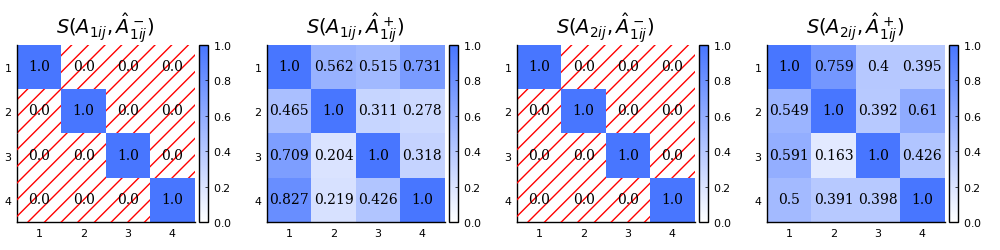

"非対角成分の算術平均: 0.0, 0.464, 0.0, 0.464"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.477, \\left[ 1.483, 1.483 \\right], 2.772 \\right] & \\left[ 2.334, \\left[ 3.578, 3.578 \\right], 6.841 \\right] & \\left[ 8.353, \\left[ 9.868, 9.868 \\right], 18.434 \\right] \\\\ \\l" ⋯ 451 bytes ⋯ "ht], 6.541 \\right] \\\\ \\left[ 0.054, \\left[ 0.101, 0.101 \\right],  0.12 \\right] & \\left[ 0.097, \\left[  0.15,  0.15 \\right], 0.275 \\right] & \\left[ 0.153, \\left[ 0.363, 0.363 \\right], 0.678 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

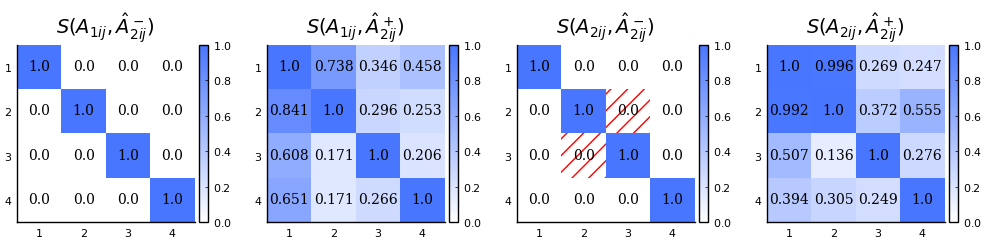

"非対角成分の算術平均: 0.0, 0.417, 0.0, 0.441"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.477, \\left[ 1.568, 1.773 \\right],  2.41 \\right] & \\left[ 2.341, \\left[ 3.837, 3.929 \\right], 4.762 \\right] & \\left[ 10.994, \\left[ 11.667, 12.922 \\right], 13.003 \\right] \\\\" ⋯ 453 bytes ⋯ "ht], 5.175 \\right] \\\\ \\left[ 0.077, \\left[ 0.077, 0.086 \\right], 0.091 \\right] & \\left[ 0.122, \\left[ 0.122,  0.15 \\right], 0.206 \\right] & \\left[ 0.193, \\left[ 0.301, 0.333 \\right], 0.404 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

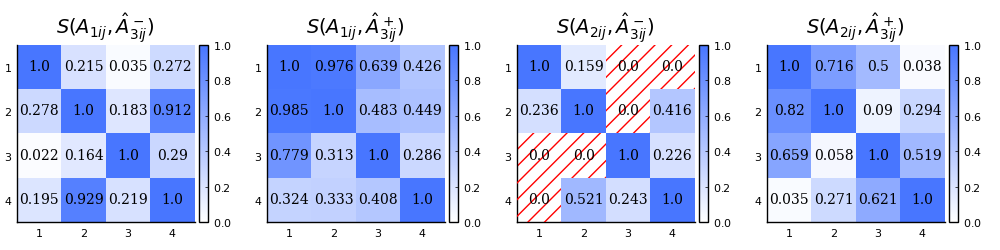

"非対角成分の算術平均: 0.31, 0.533, 0.15, 0.385"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.451, \\emptyset, 2.772 \\right] & \\left[ 2.334, \\emptyset, 5.757 \\right] & \\left[ 8.353, \\emptyset, 15.515 \\right] \\\\ \\left[ 0.361, \\emptyset, 0.689 \\right] & \\left[   1.0, \\" ⋯ 235 bytes ⋯ "0,   1.0 \\right],   1.0 \\right] & \\left[ 1.523, \\emptyset, 6.475 \\right] \\\\ \\left[ 0.064, \\emptyset,  0.12 \\right] & \\left[ 0.097, \\emptyset, 0.316 \\right] & \\left[ 0.154, \\emptyset, 0.656 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

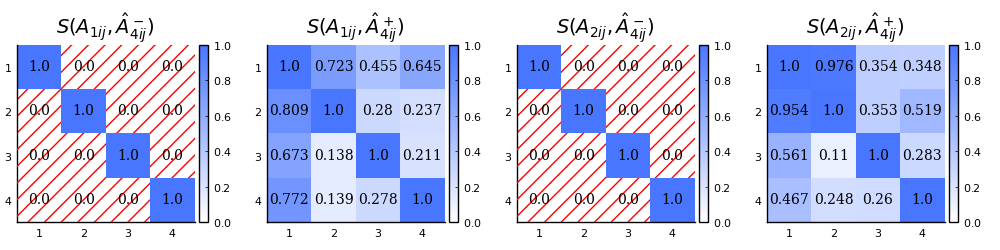

"非対角成分の算術平均: 0.0, 0.447, 0.0, 0.453"

In [12]:
A = [
    1 2 3 10
    1/2 1 3 8
    1/3 1/3 1 3
    1/10 1/8 1/3 1
]

A₁ = randamizedIntervalPCM(A, 124, 3.5e-1)
A₂ = randamizedIntervalPCM(A, 4, 3.5e-1)

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isConsistentIntervalPCM(A₁))
display(isConsistentIntervalPCM(A₂))

plotAll(A₁, A₂)

<!-- - 2 つとも整合していない
- 幅 $0.1$ の一様分布に従う乱数をもとに自然対数スケールで幅を持たせる
- $6 \times 6$

手法 3 の挙動がおかしい

```
A = [
    1 6 5 4 8 8
    1/6 1 2 2 6 4
    1/5 1/2 1 2 7 3
    1/4 1/2 1/2 1 6 5
    1/8 1/6 1/7 1/6 1 2
    1/8 1/4 1/3 1/5 1/2 1
]

A₁ = randamizedIntervalPCM(A, 234, 0.1)
A₂ = randamizedIntervalPCM(A, 134, 0.1)

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isWeaklyConsistentIntervalPCM(A₁))
display(isWeaklyConsistentIntervalPCM(A₂))

plotAll(A₁, A₂, (1600, 400))
``` -->

<!-- 幅をつける際に用いる一様分布の幅をパラメータにしてシミュレーションする，ということを考えられる．今後の課題．

重みつけたら挙動変わる？ -->

<!-- ## **conflict resolution の図で点が見づらい**
## **元の PCM が完全整合ではない場合の例が一つ欲しい**
## **非対角成分の算術平均を取った後に， DM で算術平均を取る → 内外それぞれ順番付けができる** -->

<!-- todo
- conflict resolution 見やすくする
- 元が完全整合ではない例
- 手法の順位付けの整理
- SCIS 概要送る
- 卒論概要 -->

<!-- なぜ ill-known ?  
→ この範囲については考慮すべきというのを考える．  
重要度に色々なとり方があり，正規性などがあるために基準/代替案どうしが干渉する  
→ なので区間の集合で考える -->

### 整合した区間 PCM 関連

- 重要度が存在する同じ区間 PCM 2 つ
    - 全て同じ出力
        - 手法 3 は $t_k^-, t_k^+$ の任意性があるので違う値を出してくる可能性がある
- 重要度が存在する各成分に包含関係が成り立つ 2 つの区間 PCM
    - 手法 3 のみ違う値
        - $t_k^-, t_k^+$ の任意性による
- $t_k^- = t_k^+$ にすればおそらく揃う
    - $\max\{t_k^{\text{L}-}, t_l^{\text{L}+} ~ | ~ k \in M^{'}, l \in M\} \leq t \leq \min\{t_k^{\text{U}-}, t_l^{\text{U}+} ~ | ~ k \in M^{'}, l \in M\}$
- 重要度が存在して唯一である PCM 2 つであれば全て揃うはず

### 与えられた区間 PCM との包含関係

- 手法 2, 3 の内側は数値例から $\mathscr{A}^- \subseteq A_k, k \in M$ が成り立たないことが確定
    - 手法 2 は $A_k$ を修正して得られた重みで二重区間 PCM を作っている
        - 修正を反映した $A_k$ との包含関係は保証されているはず
- 外側は不明だが手法 3 以外は直感的には大丈夫そう
- 手法 1, 4 に関しては包含関係が破れる操作をしていないので大丈夫なはず
    - 包含関係が成り立つようにできない場合は空集合になるはず

### 一致度

- 4 つともあまり差がないので数を増やして統計をとってみないと何とも言えない
    - いくつかのケースを想定して区間 PCM を作成してシミュレーション

- 手法 4 の intersection を取るところで内が空集合のものを無視するのはどうだろうか
    - 全員空集合の場合の扱いに困るが